epoch: 0, loss: 0.762725588532248
epoch: 500, loss: 0.07743129953300432
epoch: 1000, loss: 0.0011838661891997448
tensor([ 7.0669e-01+5.5511e-17j, -5.8344e-09-1.3105e-08j,
        -2.3563e-10+1.4739e-10j, -5.0291e-03+2.3677e-02j,
         5.0291e-03+2.3677e-02j, -2.3510e-10-1.4667e-10j,
         5.8582e-09-1.3094e-08j,  7.0669e-01+3.5721e-14j],
       dtype=torch.complex128, grad_fn=<MulBackward0>)


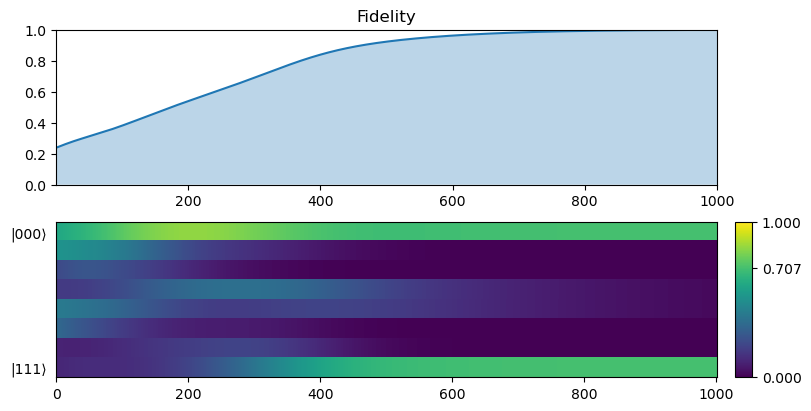

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

n_train_states = 1 #Can be |00000>

n_ghz = 3

num_layers = 2

batch_size = 1

num_epochs = 1001

learning_rate = 1e-3

loss_graph = []

q_graph = np.zeros((2**n_ghz,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================
#Create the data set

class input_vec_dataset(Dataset):
    def __init__(self):
        
        dataset = []
        labels = []

        q0 = torch.tensor([1,0],dtype=torch.complex128)
        
        basis_state = q0

        for n in range(n_ghz-1):
            basis_state = torch.kron(basis_state,q0)

        out = h @ q0
        c_not = torch.tensor([[1,0,0,0],
                              [0,1,0,0],
                              [0,0,0,1],
                              [0,0,1,0]], dtype=torch.complex128)

        for n in range(n_ghz-1):
            out = torch.kron(out,q0)
            out = c_not @ out
            c_not = torch.kron(i,c_not)

        dataset.append(basis_state)
        labels.append(out)

        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]
    
#===============================================================================================================================
#Load the data set

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================
#The model

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((1 + n_ghz,6), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((1 + n_ghz,6), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((1 + n_ghz,6), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((1 + n_ghz,6), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_ghz):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_ghz)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_ghz-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_ghz)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_ghz-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_ghz-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        q0 = torch.tensor([1,0], dtype=torch.complex128, requires_grad=False)   
        
        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                    for a in range(n_ghz // 2):
                        x = cz(2*a,2*a+1) @ x
                    for b in range(n_ghz):
                        x = U(b,layer) @ x
                    for c in range((n_ghz-1)//2):
                        x = cz(2*c+1,2*c+2) @ x
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for a in range(n_ghz // 2):
                        x = cz(2*a,2*a+1) @ x
                    for b in range(n_ghz):
                        x = U(b,layer) @ x
                    for c in range((n_ghz-1)//2):
                        x = cz(2*c+1,2*c+2) @ x
                x_out.append(x)
                x_graph = abs(x)
            
            for i in range(2**n_ghz):
                q_graph[i][epoch] = x_graph[i]
                
            return torch.stack(x_out)

#===============================================================================================================================
#Loss function

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs((1 - torch.abs(torch.dot(target_state.conj(), state))**2))
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================
#Train the model

model = HModel()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
#===============================================================================================================================
#Test the model

model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
fake_global_phase = torch.angle(q0[0])
q0 = torch.exp(-1j * fake_global_phase) * q0
print(q0) 

#===============================================================================================================================
#Graph the progress of the model

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_states / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_states / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_ghz], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(2), 1])

axis_ones = ""
for i in range(n_ghz):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_ghz):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_ghz - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_states / batch_size-1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

#===============================================================================================================================
#Suppress console output

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout